In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib
import kagglehub
import os

### Dataset

In [32]:
try:
    path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")
    file = os.listdir(path)[0]
    dataset = os.path.join(path, file)
    data = pd.read_csv(dataset)
except FileNotFoundError:
    print("Error: 'loan_approval_dataset.csv' not found. Please ensure the file is in the working directory.")
    raise

data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [19]:
data.columns = data.columns.str.strip()
print("Column names:", data.columns.tolist())

if data.empty:
    print("Error: Dataset is empty. Please check the CSV file.")
    raise ValueError("Empty dataset")

Column names: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


# EDA

In [20]:
print("Shape of dataset:\n", data.shape)
print("\nMissing values:\n", data.isnull().sum())

Shape of dataset:
 (4269, 13)

Missing values:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


Class distribution:
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


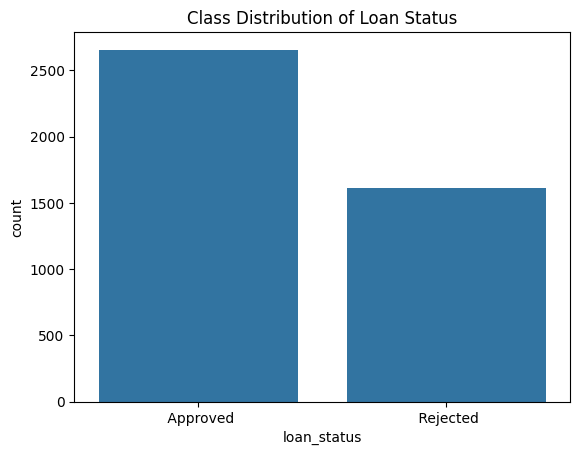

In [21]:
print("Class distribution:\n", data['loan_status'].value_counts())
sns.countplot(x='loan_status', data=data)
plt.title('Class Distribution of Loan Status')
plt.show()

In [22]:
print("Summary statistics for key numeric features:\n", data[['income_annum', 'loan_amount']].describe())

Summary statistics for key numeric features:
        income_annum   loan_amount
count  4.269000e+03  4.269000e+03
mean   5.059124e+06  1.513345e+07
std    2.806840e+06  9.043363e+06
min    2.000000e+05  3.000000e+05
25%    2.700000e+06  7.700000e+06
50%    5.100000e+06  1.450000e+07
75%    7.500000e+06  2.150000e+07
max    9.900000e+06  3.950000e+07


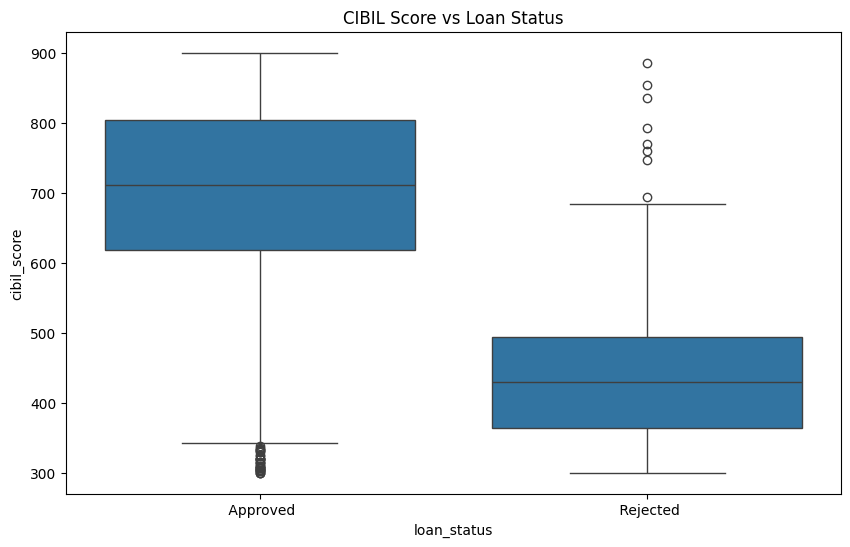

CIBIL score vs Loan status crosstab:
 loan_status     Approved  Rejected
cibil_score                       
(299.4, 420.0]        88       759
(420.0, 540.0]        91       768
(540.0, 660.0]       764        75
(660.0, 780.0]       882         7
(780.0, 900.0]       831         4


In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='cibil_score', data=data)
plt.title('CIBIL Score vs Loan Status')
plt.show()
print("CIBIL score vs Loan status crosstab:\n", pd.crosstab(pd.cut(data['cibil_score'], bins=5), data['loan_status']))

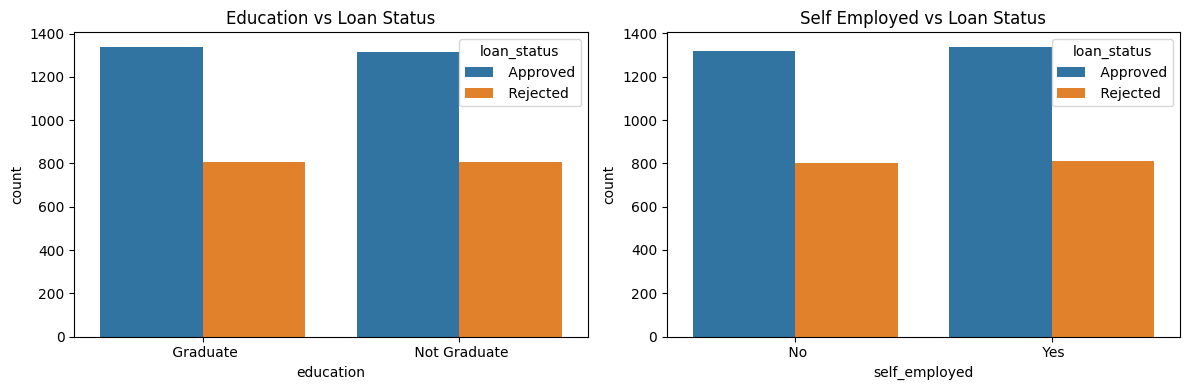

Education vs Loan status:
 loan_status   Approved  Rejected
education                       
Graduate          1339       805
Not Graduate      1317       808

Self employed vs Loan status:
 loan_status    Approved  Rejected
self_employed                    
No                 1318       801
Yes                1338       812


In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='education', hue='loan_status', data=data)
plt.title('Education vs Loan Status')
plt.subplot(1, 2, 2)
sns.countplot(x='self_employed', hue='loan_status', data=data)
plt.title('Self Employed vs Loan Status')
plt.tight_layout()
plt.show()
print("Education vs Loan status:\n", pd.crosstab(data['education'], data['loan_status']))
print("\nSelf employed vs Loan status:\n", pd.crosstab(data['self_employed'], data['loan_status']))

# ML

In [25]:
data['loan_status'] = data['loan_status'].str.strip().str.title()

# Check for values other than approved / rejected
valid_statuses = ['Approved', 'Rejected']
invalid_statuses = data[~data['loan_status'].isin(valid_statuses)]['loan_status'].unique()
if len(invalid_statuses) > 0:
    print(f"Warning: Found unexpected loan_status values: {invalid_statuses}")
    print("Dropping rows with invalid loan_status values.")
    data = data[data['loan_status'].isin(valid_statuses)]

# Encode categorical variables
data_encoded = pd.get_dummies(data, columns=['education', 'self_employed'], drop_first=True)
X = data_encoded.drop(['loan_id', 'loan_status'], axis=1)
print("Training feature names:", X.columns.tolist())
y = data_encoded['loan_status'].map({'Approved': 1, 'Rejected': 0})

Training feature names: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'education_ Not Graduate', 'self_employed_ Yes']


In [26]:
# Train-test split
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
except ValueError as e:
    print("Error during train-test split:", str(e))
    raise

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (3415, 11) (3415,)
Test set shape: (854, 11) (854,)


In [27]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Train multiple models for comparative analysis
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


In [29]:
results = {}
for name, model in models.items():
    if name == 'XGBoost':
        model.fit(X_train, y_train)  # XGBoost doesn't need scaling
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {'Accuracy': acc, 'F1-Score': f1, 'Confusion Matrix': cm}
    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(classification_report(y_test, y_pred))


Logistic Regression:
Accuracy: 0.9133
F1-Score: 0.9311
Confusion Matrix:
[[280  43]
 [ 31 500]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       323
           1       0.92      0.94      0.93       531

    accuracy                           0.91       854
   macro avg       0.91      0.90      0.91       854
weighted avg       0.91      0.91      0.91       854


Random Forest:
Accuracy: 0.9813
F1-Score: 0.9850
Confusion Matrix:
[[314   9]
 [  7 524]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854


SVM:
Accuracy: 0.9450
F1-Score: 0.9556
Confusion Matrix:
[[301  22]
 [ 25 506]]
              precision    recall  f1-score   support

           0       0.9


Comparative Analysis:
                     Accuracy  F1-Score
Logistic Regression  0.913349  0.931099
Random Forest        0.981265  0.984962
SVM                  0.944965  0.955619
XGBoost              0.980094  0.984038


<Figure size 1000x600 with 0 Axes>

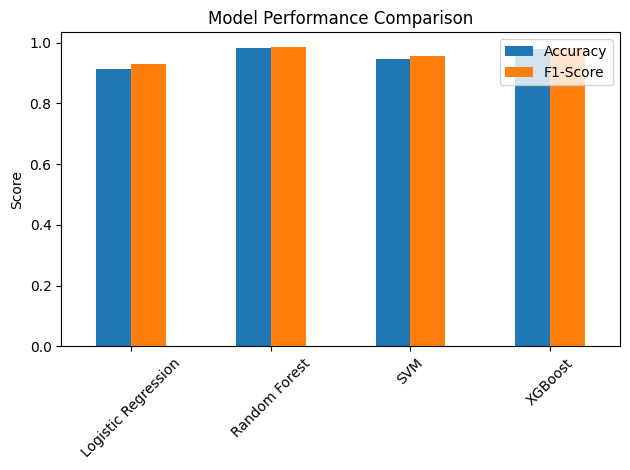

In [30]:
# Comparative analysis
results_df = pd.DataFrame(results).T
print("\nComparative Analysis:")
print(results_df[['Accuracy', 'F1-Score']])

# Visualize model performance
plt.figure(figsize=(10, 6))
results_df[['Accuracy', 'F1-Score']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
best_model_name = results_df['F1-Score'].idxmax()
best_model = models[best_model_name]
if best_model_name == 'XGBoost':
    best_model.fit(X_train, y_train)
else:
    best_model.fit(X_train_scaled, y_train)
joblib.dump(best_model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(f"\nBest model: {best_model_name} saved as model.pkl")
print("Scaler saved as scaler.pkl")


Best model: Random Forest saved as model.pkl
Scaler saved as scaler.pkl
